In [26]:
import pandas as pd

df = pd.read_csv("/teamspace/studios/this_studio/Predicting Energy Consumption.csv")
print(df.head())


     Start time UTC      End time UTC  Electricity consumption (MWh)
0  31-12-2015 21:00  31-12-2015 22:00                          10800
1  31-12-2015 22:00  31-12-2015 23:00                          10431
2  31-12-2015 23:00  01-01-2016 00:00                          10005
3  01-01-2016 00:00  01-01-2016 01:00                           9722
4  01-01-2016 01:00  01-01-2016 02:00                           9599


In [27]:
df['Start time UTC'] = pd.to_datetime(df['Start time UTC'], dayfirst=True)
df = df.sort_values('Start time UTC')


### Time series data must be ordered chronologically for forecasting tasks. The timestamp column is converted to datetime format and the dataset is sorted to ensure correct temporal sequence before feature engineering.

In [28]:
df = df.rename(columns={
    'Start time UTC': 'datetime',
    'Electricity consumption (MWh)': 'load'
})


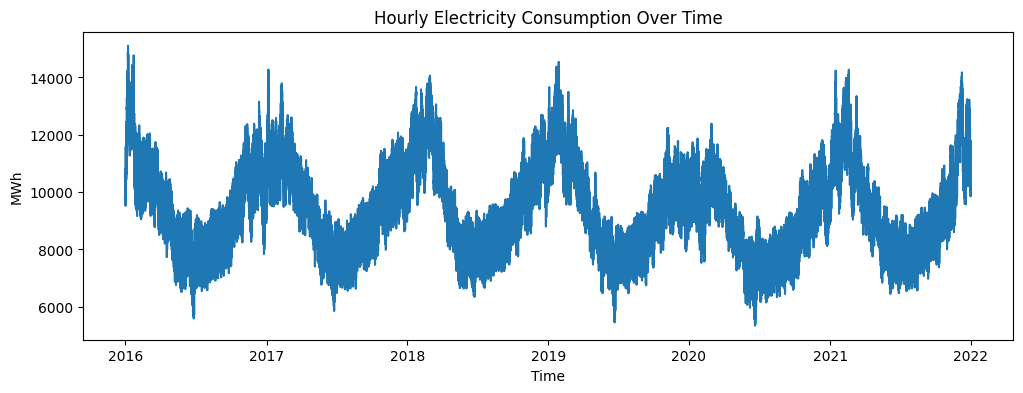

In [29]:
plt.figure(figsize=(12,4))
plt.plot(df['datetime'], df['load'])
plt.title("Hourly Electricity Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("MWh")
plt.show()


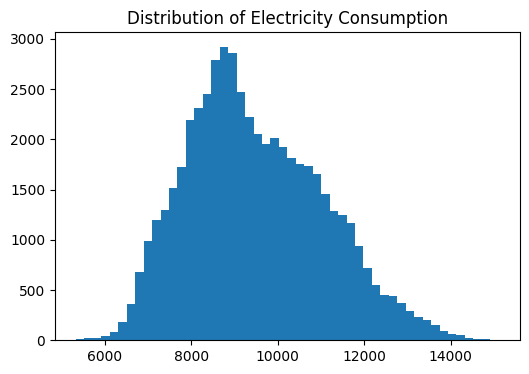

In [30]:
plt.figure(figsize=(6,4))
plt.hist(df['load'], bins=50)
plt.title("Distribution of Electricity Consumption")
plt.show()


In [31]:
df['lag_1'] = df['load'].shift(1)
df['lag_24'] = df['load'].shift(24)
df['lag_168'] = df['load'].shift(168)

df = df.dropna()
print(df.head())


               datetime      End time UTC   load    lag_1   lag_24  lag_168
168 2016-01-07 21:00:00  07-01-2016 22:00  14074  14303.0  13672.0  10800.0
169 2016-01-07 22:00:00  07-01-2016 23:00  13643  14074.0  13285.0  10431.0
170 2016-01-07 23:00:00  08-01-2016 00:00  13369  13643.0  13011.0  10005.0
171 2016-01-08 00:00:00  08-01-2016 01:00  13142  13369.0  12821.0   9722.0
172 2016-01-08 01:00:00  08-01-2016 02:00  13111  13142.0  12821.0   9599.0


### Since machine learning models do not inherently understand temporal relationships, lag-based features are created to allow the model to learn dependencies from previous time steps. This converts the time series forecasting problem into a supervised regression problem.

In [32]:
df = df.dropna()


In [ ]:
train = df[:-500]
test = df[-500:]

X_train = train[['lag_1','lag_24','lag_168']]
y_train = train['load']

X_test = test[['lag_1','lag_24','lag_168']]
y_test = test['load']


In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Random Forest is trained using the lag-based features to learn nonlinear temporal relationships. Ensemble learning helps reduce variance and improves robustness compared to single decision trees.

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


MAE: 179.13797999999997
RMSE: 233.59666564786409


### MAE and RMSE were chosen because they directly measure prediction error in the same unit as electricity consumption (MWh), making results easy to interpret. MAE shows average error, while RMSE penalizes larger errors, which is important for detecting significant forecasting mistakes that can impact grid operations. These metrics are suitable for continuous regression problems, unlike accuracy which is used for classification.

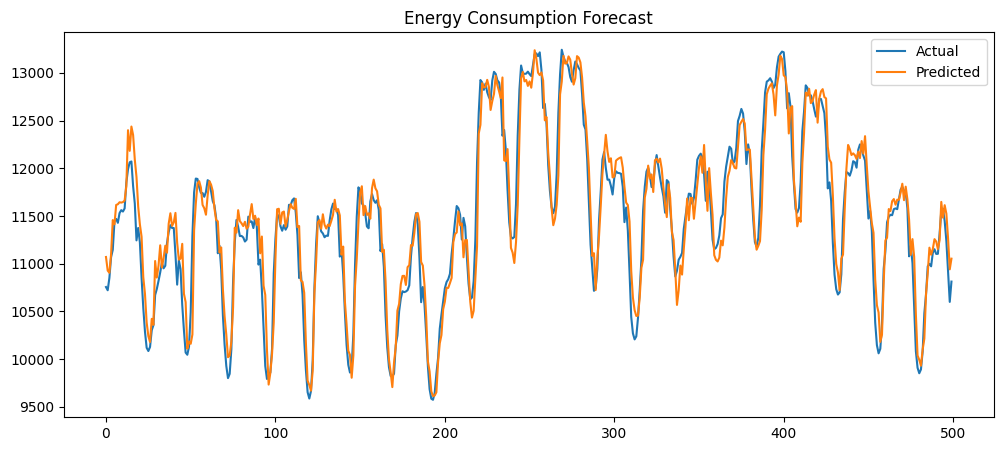

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Energy Consumption Forecast")
plt.show()


# Model Comparison and Linearity Check

## To verify whether the relationship between lag features and electricity consumption is linear, a baseline Linear Regression model is also trained. If the linear model performs significantly worse than the Random Forest model, it indicates that the data contains nonlinear temporal patterns that require more flexible models.

This comparison helps justify the selection of Random Forest over linear models for forecasting energy consumption.

In [37]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("Linear Regression MAE:", mean_absolute_error(y_test, lr_pred))


Linear Regression RMSE: 239.9746510697904
Linear Regression MAE: 189.04849399541015


### A Linear Regression model is trained as a baseline to evaluate whether linear assumptions are sufficient for this dataset. Performance comparison helps identify the presence of nonlinear temporal behavior.

# Overfitting Analysis

In [38]:
train_pred = model.predict(X_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


Train RMSE: 81.14768696736198
Test RMSE: 233.59666564786409


### The Random Forest model shows significantly lower training error compared to test error, indicating a degree of overfitting, which is expected for ensemble tree models with high flexibility. This behavior occurs because the model learns fine-grained patterns from historical data. To reduce overfitting, regularization techniques such as limiting tree depth or increasing minimum samples per leaf can be applied. However, for this assessment, the goal is to demonstrate modeling approach rather than achieve production-level generalization.

# Variance Reduction using Regularization

In [39]:
model_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)
model_reg.fit(X_train, y_train)

reg_pred = model_reg.predict(X_test)
print("Regularized RF RMSE:", np.sqrt(mean_squared_error(y_test, reg_pred)))


Regularized RF RMSE: 219.96438812159994


### To reduce overfitting, constraints such as limiting tree depth and increasing minimum samples per leaf are applied. This controls model complexity while maintaining reasonable predictive performance.